# Image captioning

Το θέμα της εργασίας είναι το image captioning, η παραγωγή δηλαδή κειμένου το οποίο περιγράφει μια εικόνα. Περιλαμβάνει ένα CNN και ένα RNN δίκτυο. Τελικός σκοπός της εργασίας είναι η εκπαίδευση και η αξιολόγηση διαφόρων προεκπαιδευμένων δικτύων CNN και δικτύων RNN.

## 1 Preprocessing

Στην εργασία χρησιμοποίηθηκε η έκδοση 2.4.1 της βιβλιοθήκης tensorflow.

In [1]:
import tensorflow as tf

print(f'tensorflow version: {tf.__version__}')

tensorflow version: 2.4.1


Δίνεται κάποιο seed στους random generators για να υπάρχει επαναληψιμότητα στα αποτελέσματα.

In [2]:
import numpy as np
import random

np.random.seed(0)
random.seed(0)

Το dataset που χρησιμοποιήθηκε είναι το Microsoft COCO dataset 2014 το οποίο αποτελείται από training, validation και test set, μεγέθους 82783, 40504 και 40775 αντίστοιχα. Κάθε δείγμα αποτελείται από μια εικόνα jpg και αντιστοιχίζεται σε μερικά captions μόνο στο training και στο validation set. Η αντιστοίχιση αυτή γίνεται στα αρχεία json.

In [3]:
import os

def download_coco_zip_and_extract(url, folder, zip):
    if not os.path.exists(folder):
        f = tf.keras.utils.get_file(zip, cache_subdir=os.path.abspath('.'), origin=url, extract=True)
        os.remove(f)

In [4]:
import time
import json

t0 = time.time()

annotation_url = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
annotation_folder = 'annotations'
annotation_zip = 'annotations.zip'

train_image_url = 'http://images.cocodataset.org/zips/train2014.zip'
train_image_folder = 'train2014'
train_image_zip = 'train2014.zip'
train_annotation_file = os.path.join(annotation_folder, 'captions_train2014.json')

val_image_url = 'http://images.cocodataset.org/zips/val2014.zip'
val_image_folder = 'val2014'
val_image_zip = 'val2014.zip'
val_annotation_file = os.path.join(annotation_folder, 'captions_val2014.json')

test_image_url = 'http://images.cocodataset.org/zips/test2014.zip'
test_image_folder = 'test2014'
test_image_zip = 'test2014.zip'

download_coco_zip_and_extract(annotation_url, annotation_folder, annotation_zip)
download_coco_zip_and_extract(train_image_url, train_image_folder, train_image_zip)
download_coco_zip_and_extract(val_image_url, val_image_folder, val_image_zip)
download_coco_zip_and_extract(test_image_url, test_image_folder, test_image_zip)

with open(train_annotation_file, 'r') as f:
    train_annotations = json.load(f)

with open(val_annotation_file, 'r') as f:
    val_annotations = json.load(f)

print(f't = {(time.time() - t0)/60:.1f} min')

t = 0.0 min


Γίνεται η αντιστοίχιση των εικόνων και των περιγραφών τους και αποθηκεύεται σε ένα dictionary. Η αρχή και το τέλος της κάθε φράσης σηματοδοτείται απο την κωδική λέξη <start\> και <end\> αντίστοιχα.

In [5]:
import collections

train_image_path_to_caption = collections.defaultdict(list)

for val in train_annotations['annotations']:
    caption = '<start> ' + val['caption'] + ' <end>'
    image_path = os.path.join(train_image_folder, 'COCO_train2014_%012d.jpg' % (val['image_id']))
    train_image_path_to_caption[image_path].append(caption)

Από το training set επιλέγονται τυχαία 50000 εικόνες οι οποίες θα χρησιμοποιηθούν για την εκπαίδευση.

In [6]:
train_size = 50000

In [7]:
train_image_paths = list(train_image_path_to_caption.keys())
np.random.shuffle(train_image_paths)

train_image_paths = train_image_paths[:train_size]
print(f'len(train_image_paths) = {len(train_image_paths)}')

len(train_image_paths) = 50000


In [8]:
train_captions = []
train_img_name_vector = []

for image_path in train_image_paths:
    caption_list = train_image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    train_img_name_vector.extend([image_path] * len(caption_list))

print(f'len(train_captions) = {len(train_captions)}')
print(f'len(train_img_name_vector) = {len(train_img_name_vector)}')

len(train_captions) = 250119
len(train_img_name_vector) = 250119


Παρακάτω φαίνεται μια εικόνα από το training set μαζί με την περιγραφή της.

<start> Two apples with faced painted on them one impaled by a knife. <end>


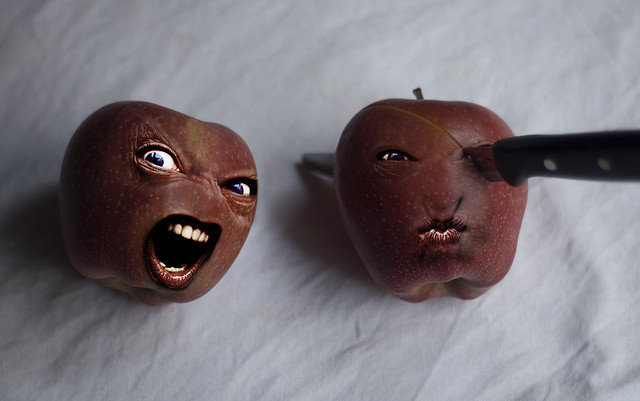

In [9]:
from IPython.display import Image

print(train_captions[0])
image = Image(train_img_name_vector[0])
display(image)

Οι περιγραφές των εικόνων συνθέτουν ένα κείμενο το οποίο δίνεται στον tf.keras.preprocessing.text.Tokenizer. Αυτός χρησιμοποιεί τις 5000 πιο συχνές λέξεις για να δημιουργήσει ένα λεξικό. Έτσι κάθε λέξη αντιστοιχίζεται σε έναν αριθμό ο οποίος μπορεί πλέον να δωθεί ως είσοδος στο νευρωνικό δίκτυο.

In [10]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [11]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>",
                                                  filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~ \t\n')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

max_length = calc_max_length(train_seqs)
vocab_size = min(top_k, len(tokenizer.word_index))
print(f'vocab_size = {vocab_size}')

vocab_size = 5000


Το 80% του training set χρησιμοποιείται για την εκπαίδευση του μοντέλου ενώ το υπόλοιπο 20% για τον υπολογισμό του validation loss.

In [12]:
img_to_cap_vector = collections.defaultdict(list)

for img, cap in zip(train_img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []

for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []

for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])
    
print(f'len(img_name_train) = {len(img_name_train)}')
print(f'len(cap_train) = {len(cap_train)}')
print(f'len(img_name_val) = {len(img_name_val)}')
print(f'len(cap_val) = {len(cap_val)}')

len(img_name_train) = 200092
len(cap_train) = 200092
len(img_name_val) = 50027
len(cap_val) = 50027


## 2 Training and Evaluation

### 2.1 Features

Κάθε εικόνα μετατρέπεται σε εικόνα μεγέθους 299x299 και έχει 3 κανάλια RGB. Περνάει πρώτα απο το προεκπαιδευμένο δίκτυο το οποίο έχει εκπαιδευθεί στην ImageNet. Από αυτό χρησιμοποιείται μόνο το κομμάτι με τα convolutional layers. Τα τελευταία dense layers δεν χρησιμοποιούνται γιατί περιέχουν την εξειδικευμένη γνώση για το classification στις κλάσεις της ImageNet. Κάθε εικόνα περνάει μια φορά μέσα από αυτό το δίκτυο και η έξοδος του αποθηκεύεται στον δίσκο. Αυτά τα αποθηκευμένα features είναι σταθερά για κάθε εικόνα, αφού δεν πρόκεται να ξαναεκπαιδεύσουμε το convolutional κομμάτι του μοντέλου. Έτσι κερδίζουμε σε χρόνο εκπαίδευσης.

In [13]:
input_shape = (299, 299, 3)

In [14]:
BATCH_SIZE = 32
BUFFER_SIZE = 256
EMBEDDING_DIM = 256
UNITS = 512

In [15]:
all_data = {}

def set_data(key, data, cnn_name, rnn_name=''):
    all_data[cnn_name + rnn_name + key] = data

def get_data(key, cnn_name, rnn_name=''):
    return all_data[cnn_name + rnn_name + key]

In [16]:
from tqdm import tqdm
import shutil

image_features_folder = 'features'
model_name_to_data = {}

def save_features(cnn_name, cnn_model, load_image_fun):
    image_features_extract_model = tf.keras.Model(cnn_model.input, cnn_model.layers[-1].output)

    if os.path.exists(image_features_folder):
        shutil.rmtree(image_features_folder)

    if not os.path.exists(image_features_folder):
        os.mkdir(image_features_folder)

        encode_train = sorted(set(train_img_name_vector))

        image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
        image_dataset = image_dataset.map(load_image_fun).batch(BATCH_SIZE)

        for img, path in tqdm(image_dataset):
            batch_features = image_features_extract_model(img)
            batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

            for bf, p in zip(batch_features, path):
                path_of_feature = p.numpy().decode("utf-8")
                path_of_feature = os.path.join(image_features_folder, os.path.basename(path_of_feature))
                np.save(path_of_feature, bf.numpy())

    set_data('image_features_extract_model', image_features_extract_model, cnn_name)
    set_data('load_image_fun', load_image_fun, cnn_name)

### 2.2 Model

Το μοντέλο αποτελείται απο δύο μέρη, τον CNN encoder και τον RNN decoder. Ο CNN encoder ρίχει τη διάσταση των αποθηκευμένων features σε 256. Ο RNN decoder χρησιμοποιεί ένα GRU ή ένα LSTM. Έχει ως είσοδο τα features του CNN και την προηγούμενη λέξη που είχε βγάλει ως έξοδο. Στην έξοδο, χρησιμοποιώντας softmax activation function, αποφασίζει ποια είναι η επόμενη λέξη της περιγραφής. Η αντιστοίχιση αριθμού σε λέξη γίνεται με τον tokenizer. Η φράση τελειώνει μόλις εμφανιστεί στην έξοδο η κωδική λέξη <end\>.

In [17]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, rnn_model):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn_model = rnn_model
        if rnn_model == 'GRU':
            self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True,
                                        recurrent_initializer='glorot_uniform')
        elif rnn_model == 'LSTM':
            self.lstm = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True,
                                             recurrent_initializer='glorot_uniform')
        else:
            raise Exception('Invalid rnn_model')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        if self.rnn_model == 'GRU':
            output, state = self.gru(x)
        elif self.rnn_model == 'LSTM':
            output, state, _ = self.lstm(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### 2.3 Training

Η εκπαίδευση του μοντέλου γίνεται για 10 εποχές. Με το που τελειώνει η εκπαίδευση το μοντέλο επαναφέρεται στην εποχή που είχε το μικρότερο validation loss. Έτσι αποφεύγεται η υπερπροσαρμογή.

In [18]:
def loss_function(real, pred, loss_object):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def train_step(img_tensor, target, encoder, decoder, optimizer, loss_object):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions, loss_object)
            dec_input = tf.expand_dims(target[:, i], 1)
            
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return (loss / int(target.shape[1]))

def eval_step(img_tensor, target, encoder, decoder, optimizer, loss_object):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions, loss_object)
        dec_input = tf.expand_dims(target[:, i], 1)
            
    return (loss / int(target.shape[1]))

def map_func(img_name, cap):
    filename = img_name.decode('utf-8') + '.npy'
    filename = os.path.join(image_features_folder, os.path.basename(filename))
    img_tensor = np.load(filename)
    return img_tensor, cap

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=BUFFER_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]))
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=BUFFER_SIZE)

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import pickle

results = []
results_pickle = '/content/drive/MyDrive/results.pkl'

def new_results():
    results.append([])

def add_to_results(key, val):
    results[-1].append((key, val))

def save_results():
    with open(results_pickle, 'wb') as pickle_file:
        pickle.dump(results, pickle_file)

def load_results():
    with open(results_pickle, 'rb') as pickle_file:
        global results
        results = pickle.load(pickle_file)

# load_results()

for res in results:
    for key, val in res:
        print(f'{key}: {val}')
    print()

In [22]:
import matplotlib.pyplot as plt

def train_model(cnn_name, rnn_name):
    t0 = time.time()

    encoder = CNN_Encoder(EMBEDDING_DIM)
    decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, vocab_size, rnn_name)

    optimizer = tf.keras.optimizers.Adam()
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    EPOCHS = 10
    epochs = range(1, EPOCHS+1)
    loss_plot = []
    v_loss_plot = []
    best_v_loss = None
    best_epoch = None
    checkpoints_folder = 'checkpoints'

    if os.path.exists(checkpoints_folder):
        shutil.rmtree(checkpoints_folder)

    ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoints_folder, max_to_keep=None)

    train_step_fun = tf.function(train_step)
    eval_step_fun = tf.function(eval_step)

    for epoch in epochs:
        t1 = time.time()
        total_loss = 0
        total_v_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            total_loss += train_step_fun(img_tensor, target, encoder, decoder, optimizer, loss_object)
        avg_loss = total_loss / len(dataset)
        loss_plot.append(avg_loss)
        
        for (batch, (img_tensor, target)) in enumerate(val_dataset):
            total_v_loss += eval_step_fun(img_tensor, target, encoder, decoder, optimizer, loss_object)
        avg_v_loss = total_v_loss / len(val_dataset)
        v_loss_plot.append(avg_v_loss)
        
        if best_v_loss is None or avg_v_loss < best_v_loss:
            best_v_loss = avg_v_loss
            best_epoch = epoch
            ckpt_manager.save(checkpoint_number=epoch+1)
        
        print(f'Epoch {epoch:02d}: loss = {avg_loss:.4f}, val_loss = {avg_v_loss:.4f}, t = {(time.time() - t1)/60:.1f} min')

    t = time.time() - t0
    print(f'Total training time: {t/60:.1f} min')

    print(f'Restoring model to epoch: {best_epoch}')
    ckpt.restore(ckpt_manager.latest_checkpoint)

    new_results()
    add_to_results('Model', f'{cnn_name} + {rnn_name}')
    add_to_results('Training time', t)

    set_data('encoder', encoder, cnn_name, rnn_name)
    set_data('decoder', decoder, cnn_name, rnn_name)

    plt.plot(epochs, loss_plot, label='Training loss')
    plt.plot(epochs, v_loss_plot, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.legend()
    plt.show()

### 2.4 Evaluation

Γίνεται αξιολόγηση του μοντέλου πάνω σε 5000 εικόνες του validation set που δεν έχουν χρησιμοποιηθεί καθόλου στην εκπαίδευση. Η αξιολόγηση γίνεται χρησιμοποιώντας τις μετρικές BLEU, Meteor, Rouge-L, CIDEr και SPICE χρησιμοποιώντας την βιβλιοθήκη pycocoevalcap. Επίσης εμφανίζεται μια τυχαία εικόνα από το validation set, τα true caption της, το predicted caption και το attention plot, δηλαδη τα μέρη της εικόνας τα οποία επηρέασαν περισσότερο το μόντελο για να αποφασίσει την κάθε λέξη της φράσης. Το ίδιο γίνεται με μια τυχαία εικόνα απο το test set και με μια συγκεκριμένη εικόνα ενός surfer.

In [23]:
val_size = 5000

In [24]:
val_image_id_to_caption = collections.defaultdict(list)

for val in val_annotations['annotations']:
    image_id = val['image_id']
    caption = val['caption']
    val_image_id_to_caption[image_id].append(caption)
    
val_image_ids = sorted(list(val_image_id_to_caption.keys()))
np.random.shuffle(val_image_ids)
val_image_ids = val_image_ids[:val_size]

In [25]:
!pip install pycocoevalcap

In [26]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

def predict_image_caption(image_path, image_features_extract_model,
                          load_image_fun, encoder, decoder):
    temp_input = tf.expand_dims(load_image_fun(image_path)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)

    result = []
    hidden = decoder.reset_state(batch_size=1)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            break
        dec_input = tf.expand_dims([predicted_id], 0)
    result = ' '.join(result)

    return result

def create_results_file(cnn_name, rnn_name):
    image_features_extract_model = get_data('image_features_extract_model', cnn_name)
    load_image_fun = get_data('load_image_fun', cnn_name)
    encoder = get_data('encoder', cnn_name, rnn_name)
    decoder = get_data('decoder', cnn_name, rnn_name)
    json_data = []

    for image_id in tqdm(val_image_ids):
        image_path = os.path.join(val_image_folder, 'COCO_val2014_%012d.jpg' % (image_id))
        result = predict_image_caption(image_path, image_features_extract_model,
                                       load_image_fun, encoder, decoder)
        json_data.append({'image_id': image_id, 'caption': result})

    results_file = 'captions_val2014_results.json'
    with open(results_file, 'w') as outfile:
        json.dump(json_data, outfile)
    
    return results_file

def coco_eval_results_file(results_file):
    coco = COCO(val_annotation_file)
    coco_result = coco.loadRes(results_file)

    coco_eval = COCOEvalCap(coco, coco_result)
    coco_eval.params['image_id'] = coco_result.getImgIds()
    coco_eval.evaluate()

    print()
    for metric, score in coco_eval.eval.items():
        add_to_results(metric, score)
        print(f'{metric}: {score:.4f}')

def evaluate_model_on_validation_set(cnn_name, rnn_name):
    results_file = create_results_file(cnn_name, rnn_name)
    coco_eval_results_file(results_file)

In [27]:
import PIL

def plot_attention(image, result, attention_plot):
    temp_image = np.array(PIL.Image.open(image))

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

def evaluate_image(image, cnn_name, rnn_name):
    image_features_extract_model = get_data('image_features_extract_model', cnn_name)
    load_image_fun = get_data('load_image_fun', cnn_name)
    encoder = get_data('encoder', cnn_name, rnn_name)
    decoder = get_data('decoder', cnn_name, rnn_name)

    output = image_features_extract_model.layers[-1].output
    attention_features_shape = output.shape[1] * output.shape[2]
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image_fun(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

rid = np.random.randint(0, len(val_image_ids))
val_image_id = val_image_ids[rid]

def evaluate_model_on_validation_image(cnn_name, rnn_name):
    image_path = os.path.join(val_image_folder, 'COCO_val2014_%012d.jpg' % (val_image_id))
    real_captions = val_image_id_to_caption[val_image_id]
    result, attention_plot = evaluate_image(image_path, cnn_name, rnn_name)

    for real_caption in real_captions:
        print('True caption:', real_caption)
    print('Predicted caption:', ' '.join(result))
    plot_attention(image_path, result, attention_plot)
    display(Image(image_path))

In [28]:
test_image_paths = []

for image_path in os.listdir(test_image_folder):
    image_path = os.path.join(test_image_folder, image_path)
    test_image_paths.append(image_path)

In [29]:
rid = np.random.randint(0, len(test_image_paths))
test_image_path = test_image_paths[rid]

def evaluate_model_on_test_image(cnn_name, rnn_name):
    result, attention_plot = evaluate_image(test_image_path, cnn_name, rnn_name)

    print('Predicted caption:', ' '.join(result))
    plot_attention(image_path, result, attention_plot)
    display(Image(image_path))

def evaluate_model_on_test_set(cnn_name, rnn_name):
    evaluate_model_on_test_image(cnn_name, rnn_name)

In [30]:
def evaluate_model_on_surf_image(cnn_name, rnn_name):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_extension = image_url[-4:]
    image_path = tf.keras.utils.get_file('image' + image_extension, origin=image_url)

    t0 = time.time()
    result, attention_plot = evaluate_image(image_path, cnn_name, rnn_name)
    t = time.time() - t0
    add_to_results('Prediction time', t)
    save_results()
    print('Predicted caption:', ' '.join(result))
    plot_attention(image_path, result, attention_plot)
    display(Image(image_path))

## 3 Models

Παρακάτω γίνεται εκπαίδευση και αξιολόγηση του μοντέλου χρησιμοποιώντας κάθε φορά διαφορετικό προεκπαιδευμένο CNN.

### 3.1 VGG16

In [31]:
def load_image_VGG16(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, input_shape[:2])
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img, image_path

In [ ]:
save_features('VGG16', tf.keras.applications.VGG16(include_top=False, input_shape=input_shape),
            load_image_VGG16)

  5%|▍         | 75/1563 [00:30<10:39,  2.33it/s]

#### 3.1.1 GRU

In [ ]:
train_model('VGG16', 'GRU')

In [ ]:
evaluate_model_on_validation_set('VGG16', 'GRU')

In [ ]:
evaluate_model_on_validation_image('VGG16', 'GRU')

In [ ]:
evaluate_model_on_test_image('VGG16', 'GRU')

In [ ]:
evaluate_model_on_surf_image('VGG16', 'GRU')

#### 3.1.2 LSTM

In [ ]:
train_model('VGG16', 'LSTM')

In [ ]:
evaluate_model_on_validation_set('VGG16', 'LSTM')

In [ ]:
evaluate_model_on_validation_image('VGG16', 'LSTM')

In [ ]:
evaluate_model_on_test_image('VGG16', 'LSTM')

In [ ]:
evaluate_model_on_surf_image('VGG16', 'LSTM')

### 3.2 MobileNetV2

In [ ]:
def load_image_MobileNetV2(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, input_shape[:2])
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img, image_path

In [ ]:
save_features('MobileNetV2', tf.keras.applications.MobileNetV2(include_top=False, input_shape=input_shape),
            load_image_MobileNetV2)

#### 3.3.1 GRU

In [ ]:
train_model('MobileNetV2', 'GRU')

In [ ]:
evaluate_model_on_validation_set('MobileNetV2', 'GRU')

In [ ]:
evaluate_model_on_validation_image('MobileNetV2', 'GRU')

In [ ]:
evaluate_model_on_test_image('MobileNetV2', 'GRU')

In [ ]:
evaluate_model_on_surf_image('MobileNetV2', 'GRU')

#### 3.3.2 LSTM

In [ ]:
train_model('MobileNetV2', 'LSTM')

In [ ]:
evaluate_model_on_validation_set('MobileNetV2', 'LSTM')

In [ ]:
evaluate_model_on_validation_image('MobileNetV2', 'LSTM')

In [ ]:
evaluate_model_on_test_image('MobileNetV2', 'LSTM')

In [ ]:
evaluate_model_on_surf_image('MobileNetV2', 'LSTM')

### 3.3 InceptionV3

In [ ]:
def load_image_InceptionV3(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, input_shape[:2])
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
save_features('InceptionV3', tf.keras.applications.InceptionV3(include_top=False, input_shape=input_shape),
            load_image_InceptionV3)

#### 3.2.1 GRU

In [ ]:
train_model('InceptionV3', 'GRU')

In [ ]:
evaluate_model_on_validation_set('InceptionV3', 'GRU')

In [ ]:
evaluate_model_on_validation_image('InceptionV3', 'GRU')

In [ ]:
evaluate_model_on_test_image('InceptionV3', 'GRU')

In [ ]:
evaluate_model_on_surf_image('InceptionV3', 'GRU')

#### 3.2.2 LSTM

In [ ]:
train_model('InceptionV3', 'LSTM')

In [ ]:
evaluate_model_on_validation_set('InceptionV3', 'LSTM')

In [ ]:
evaluate_model_on_validation_image('InceptionV3', 'LSTM')

In [ ]:
evaluate_model_on_test_image('InceptionV3', 'LSTM')

In [ ]:
evaluate_model_on_surf_image('InceptionV3', 'LSTM')

## 4 Final Results

### 4.1 Scores

In [ ]:
def plot_results(df, ylabel, width, size):
    labels = [x[0][1] for x in df]
    x = np.arange(len(labels))

    fig, ax = plt.subplots()
    scores_len = len(df[0][1:])
    for i in range(scores_len):
        score_label = df[0][i+1][0]
        scores = [x[i+1][1] for x in df]
        rects = ax.bar(x+(i-scores_len//2)*width, scores, width, label=score_label)

    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

    fig.set_size_inches(size[0], size[1])

    plt.show()

In [ ]:
import pandas as pd

scores = [[x[0]] + x[2:-1] for x in results]
df_columns = [x[0] for x in scores[0]]
df_data = [dict(x) for x in scores]
pd.DataFrame(df_data, columns=df_columns)

In [ ]:
plot_results(scores, 'Scores', 0.08, (17, 8))

### 4.2 Times

#### 4.2.1 Training

In [ ]:
training_times = [x[0:2] for x in results]
df_columns = [x[0] for x in training_times[0]]
df_data = [dict(x) for x in training_times]
pd.DataFrame(df_data, columns=df_columns)

In [ ]:
plot_results(training_times, 'Training time (s)', 0.4, (15, 8))

#### 4.2.2 Prediction

In [ ]:
prediction_times = [[x[0]] + [x[-1]] for x in results]
df_columns = [x[0] for x in prediction_times[0]]
df_data = [dict(x) for x in prediction_times]
pd.DataFrame(df_data, columns=df_columns)

In [ ]:
plot_results(prediction_times, 'Prediction time (s)', 0.4, (15, 8))

## 5 References

1. Dataset: https://cocodataset.org/#home
2. Tutorial: https://www.tensorflow.org/tutorials/text/image_captioning
3. Evaluation metrics: https://pypi.org/project/pycocoevalcap/


